### Evaluation & Metrics

This notebook evaluates the performance of two main tasks in our NLP pipeline:
1. **Resume Classification** (Supervised Learning)
2. **Job Matching** (Unsupervised Similarity)

We assess classification accuracy, precision, recall, F1-score, and cosine similarity for matching relevance.


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### **Resume Classification – Supervised Learning**

- We aim to classify resumes into predefined categories such as HR, Engineering, IT, etc. using a machine learning pipeline with TF-IDF and LinearSVC. 

- The goal is to evaluate how well our classifier distinguishes between job domains based on resume content.

##### **Data Prep & TF-IDF:**

In [2]:
#Loading the data
resumes_df = pd.read_csv("Cleaned_Resume.csv")  
X = resumes_df["Cleaned_Resume"].fillna("")
y = resumes_df["Category"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

##### **Model Training & Evaluation:**

- We train a Linear Support Vector Classifier (LinearSVC) using the TF-IDF features. We then evaluate the model using standard classification metrics.

##### **Model Fit & Metrics:**

In [7]:
clf = LinearSVC(C=1.0)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [8]:
print("Resume Classification Results")
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Resume Classification Results
Accuracy: 71.63 %

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.87      0.90      0.88        29
              ADVOCATE       0.61      0.73      0.67        30
           AGRICULTURE       0.25      0.12      0.17         8
               APPAREL       0.65      0.55      0.59        20
                  ARTS       0.55      0.33      0.41        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.75      0.86      0.80        21
               BANKING       0.80      0.70      0.74        23
                   BPO       0.50      0.50      0.50         2
  BUSINESS-DEVELOPMENT       0.96      0.81      0.88        27
                  CHEF       0.89      0.71      0.79        24
          CONSTRUCTION       0.88      0.82      0.85        34
            CONSULTANT       0.57      0.40      0.47        20
              DESIGNER       0.

##### **Confusion Matrix:**

- The confusion matrix gives a class-by-class breakdown of true vs predicted labels. This helps visualize which resume categories are being confused the most.

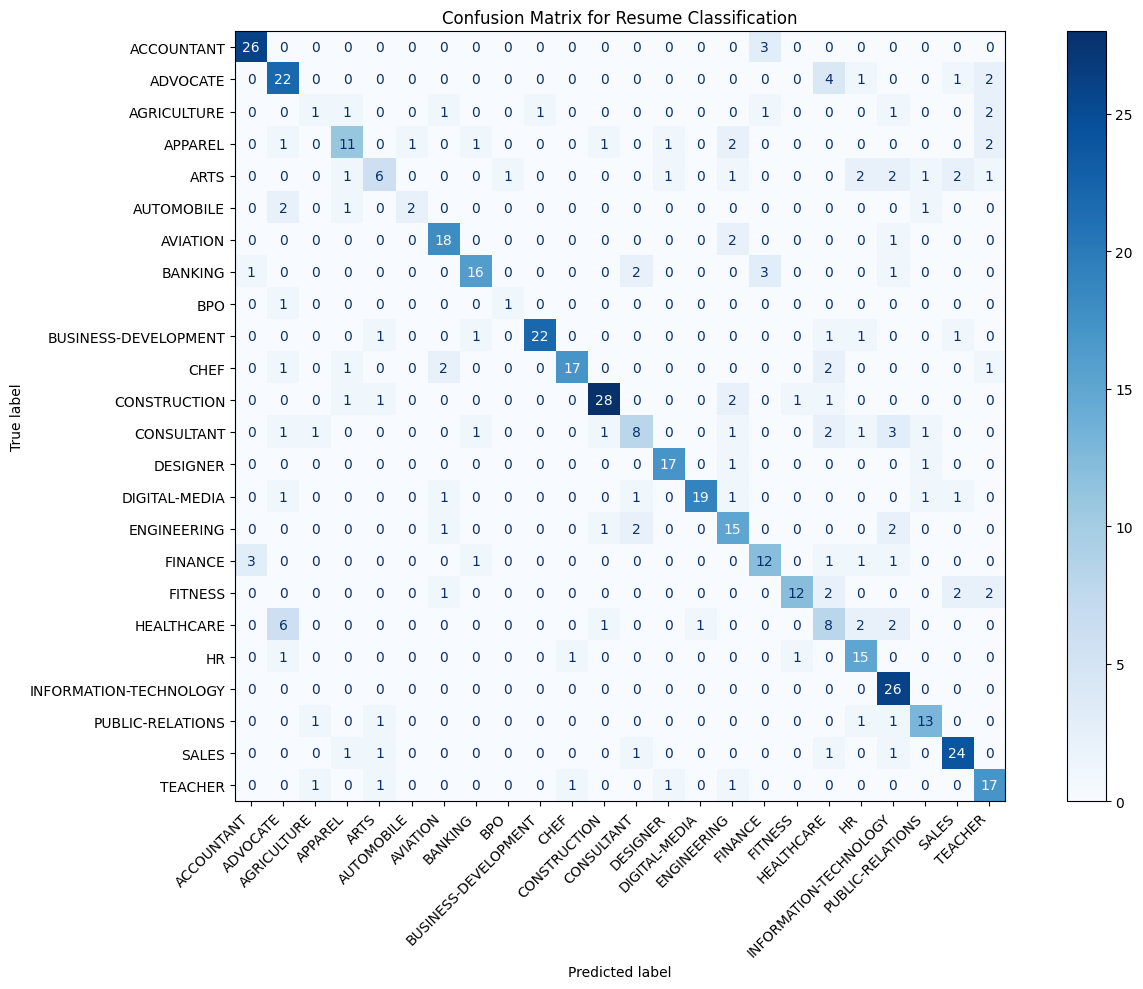

In [11]:
labels = sorted(list(set(y_test)))

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(14, 10))  # Wider figure
disp.plot(ax=ax, cmap="Blues", colorbar=True)

# Improve readability
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.yticks(rotation=0)
plt.title("Confusion Matrix for Resume Classification")
plt.tight_layout()
plt.grid(False)
plt.show()

#### **Job Matching – Evaluation & Metrics (Unsupervised Cosine Similarity)**

- This task matches resumes to job postings based on semantic similarity. We use a Bag-of-Words model via CountVectorizer, followed by cosine similarity to rank relevance.

- The output is the **mean Top-5 similarity score**, representing how well each resume matches to any job.

In [18]:
resumes_df = pd.read_csv("Cleaned_Resume.csv")            # Replace with actual path
jobs_df = pd.read_csv("postings_enriched.csv")            # Replace with actual path
job_skills_df = pd.read_csv("job_skills_cleaned.csv")
skills_df = pd.read_csv("skills_cleaned.csv")

In [19]:
job_skills_df = job_skills_df.merge(skills_df, on="skill_abr", how="left")
skills_per_job = (
    job_skills_df.groupby("job_id")["skill_name"]
    .apply(lambda x: " ".join(x.dropna()))
    .reset_index()
)
jobs_df = jobs_df.merge(skills_per_job, on="job_id", how="left")

In [20]:
jobs_df["job_text"] = (
    jobs_df["Cleaned_Title"].fillna("") + " " +
    jobs_df["Cleaned_Description"].fillna("") + " " +
    jobs_df["skill_name"].fillna("")
)

In [21]:
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 1), stop_words='english')

In [26]:
resumes_text_clean = resumes_df["Cleaned_Resume"].fillna("")
jobs_text_clean = jobs_df["job_text"].fillna("")
combined_text = pd.concat([resumes_text_clean, jobs_text_clean])

vectorizer.fit(combined_text)
resume_vecs = vectorizer.transform(resumes_text_clean)
job_vecs = vectorizer.transform(jobs_text_clean)

In [27]:
sim_matrix = cosine_similarity(resume_vecs, job_vecs)

In [28]:
top5_scores = [np.mean(np.sort(row)[-5:]) for row in sim_matrix]
mean_top5_similarity = np.mean(top5_scores)

In [29]:
print("Job Matching Results")
print("Mean Top-5 Cosine Similarity Score:", round(mean_top5_similarity, 4))

Job Matching Results
Mean Top-5 Cosine Similarity Score: 0.4371


- The **Mean Top-5 Cosine Similarity Score** quantifies how well each resume matches to any of the top 5 job descriptions.

- In our case, a score of **0.4371** suggests moderate semantic alignment between resumes and postings. This can be further improved with advanced embeddings (e.g., BERT).